In [1]:
import numpy as np
import pandas as pd
from plotnine import *

In [2]:
df_train = pd.read_csv('trainData.csv')
df_train.head()

,Unnamed: 0,date,fligth_number,origin,destination,distance,noshow,denied_boarding,pax_midlow,pax_high,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,389083,2009-11-09,8995,BBA,SCL,1394,9.0,0,94,2,...,22,19,0,1,0,239,10:30:00,174.0,10631.1,240
1,177073,2009-05-23,7061,LIM,TRU,489,0.0,0,100,4,...,25,0,0,19,9,192,19:20:00,174.0,5453.7,220
2,1040357,2011-05-09,8972,SCL,PUQ,2180,4.0,0,7,1,...,2,0,0,0,10,69,09:54:00,218.0,16161.0,79
3,505258,2010-02-12,6039,CGH,CNF,524,13.0,0,54,4,...,4,0,0,26,0,64,21:00:00,174.0,10828.7,90
4,369663,2009-10-24,7713,GPS,GYE,1170,14.0,0,21,88,...,0,88,1,23,3,183,12:40:00,144.0,16721.6,209


# Limpieza de datos

In [3]:
# Eliminar columna Unnamed: 0; parece ser un identificador innecesario
df_train = df_train.drop(columns=["Unnamed: 0"])

Revisar datos faltantes:

In [4]:
df_train.isna().sum()
# La variable departure_time "hora programada de despegue" presenta datos nulos

date                  0
fligth_number         0
origin                0
destination           0
distance              0
noshow                0
denied_boarding       0
pax_midlow            0
pax_high              0
pax_midhigh           0
pax_low               0
pax_freqflyer         0
group_bookings        0
out_of_stock          0
dom_cnx               0
int_cnx               0
p2p                   0
departure_time     1418
capacity              0
revenues_usd          0
bookings              0
dtype: int64

Se tienen sólo 1418 valores faltantes en la variable 'departure_time'.
Consideramos que esta variable puede ser relevante para el trabajo, porque indica la hora en que debe salir el avión, y es probable que esto afecte en la cantidad de 'no show'. 
Como se tienen 999890 filas, y 1418 filas con datos faltantes, son sólo el 0.14% de los datos.

Podriamos eliminar los nulos, pero como el df_test tambien tiene faltantes y necesitamos predecir si o si todos los test, podemos
- eliminar la variable completa
- imputar por media o mediana


Por mientras, imputamos por la mediana.
Pero para esto, primero tenemos que trabajar los formatos, no se puede calcular la mediana con el formato hh:mm:ss

**Revisar los Formatos:**

Para las variables de fechas y tiempo, debemos ajustar los formatos, ya que no nos sirven tal como están para el modelo.
- **date:** esta en formato yyyy:mm:dd. Para predecir, no nos interesa realmente el año, no entrega info. para predecir (no vamos a volver a esos años). El día del mes tampoco es relevante, considerando el problema. El mes podría contener información interesante, por ejemplo por las fechas que tienen más viajes como Navidad, por lo que dejamos sólo esa información.

Quizás podemos sacar date? Para tener menos variables y no creo que sea muy relevante (hay viajes todo el año)

- **departure_time:** La variable 'departure_time' tiene formato hh:mm:ss. No nos sirve así, y la información realmente relevante es la hora en sí (hh), por lo que conservamos sólo esa parte. (Quizás viajes en la madrugada se pierden más pq no llegan o algo así?)

In [5]:
import pandas as pd

# Transformación para date:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].dt.month
df_train = df_train.drop(columns='date')

# Transformación para departure_time:
df_train['departure_time'] = pd.to_datetime(df_train['departure_time'], errors='coerce')  # Transformación y manejo de NaT
# Extrae solo la hora de inicio (hh) y reemplaza NaT con un -1 por mientras
df_train['departure_time'] = df_train['departure_time'].apply(lambda x: x.hour if not pd.isna(x) else -1)

# Calcula la mediana de las horas de inicio (ignorando los valores -1)
median_departure_time = df_train['departure_time'][df_train['departure_time'] != -1].median()

# Imputa los valores -1 en 'departure_time' con la mediana
df_train['departure_time'].replace(-1, median_departure_time, inplace=True)

C:\Users\acata\AppData\Local\Temp\ipykernel_25296\364324107.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


**Con respecto a las variables categóricas nominales:**
- origin: Aeropuerto de origen
- destination: Aeropuerto de destino

Consideramos la opción de hacer one-hot encoding, lo que crearía demasiadas variables binarias, las que no son ideales para métodos de distancia como KNN-regressor (ya que no existe un concepto real de distancia). 
Entonces, considerando que la información sobre el aeropuerto no parece vital para predecir el número de no-shows, no consideraremos estas en el df final.

Luego, para la variable 
- 'denied_boarding': indica el número de pasajeros que no pudieron abordar por vuelo sobre reservado. 

Como el objetivo principal de este proyecto es estimar el número de no show en su vuelo, **antes** de que salga un vuelo, no se debería usar esta variable como predictora, por lo que tampoco se considera en el df.

In [6]:
# Eliminar las columnas origin, destination y denied_boarding del df
columnas_eliminar = ['origin', 'destination', 'denied_boarding']
df_train = df_train.drop(columns=columnas_eliminar)

Para las **variables numéricas**, hacemos boxplots para tener una idea general de los datos y ver posibles outliers

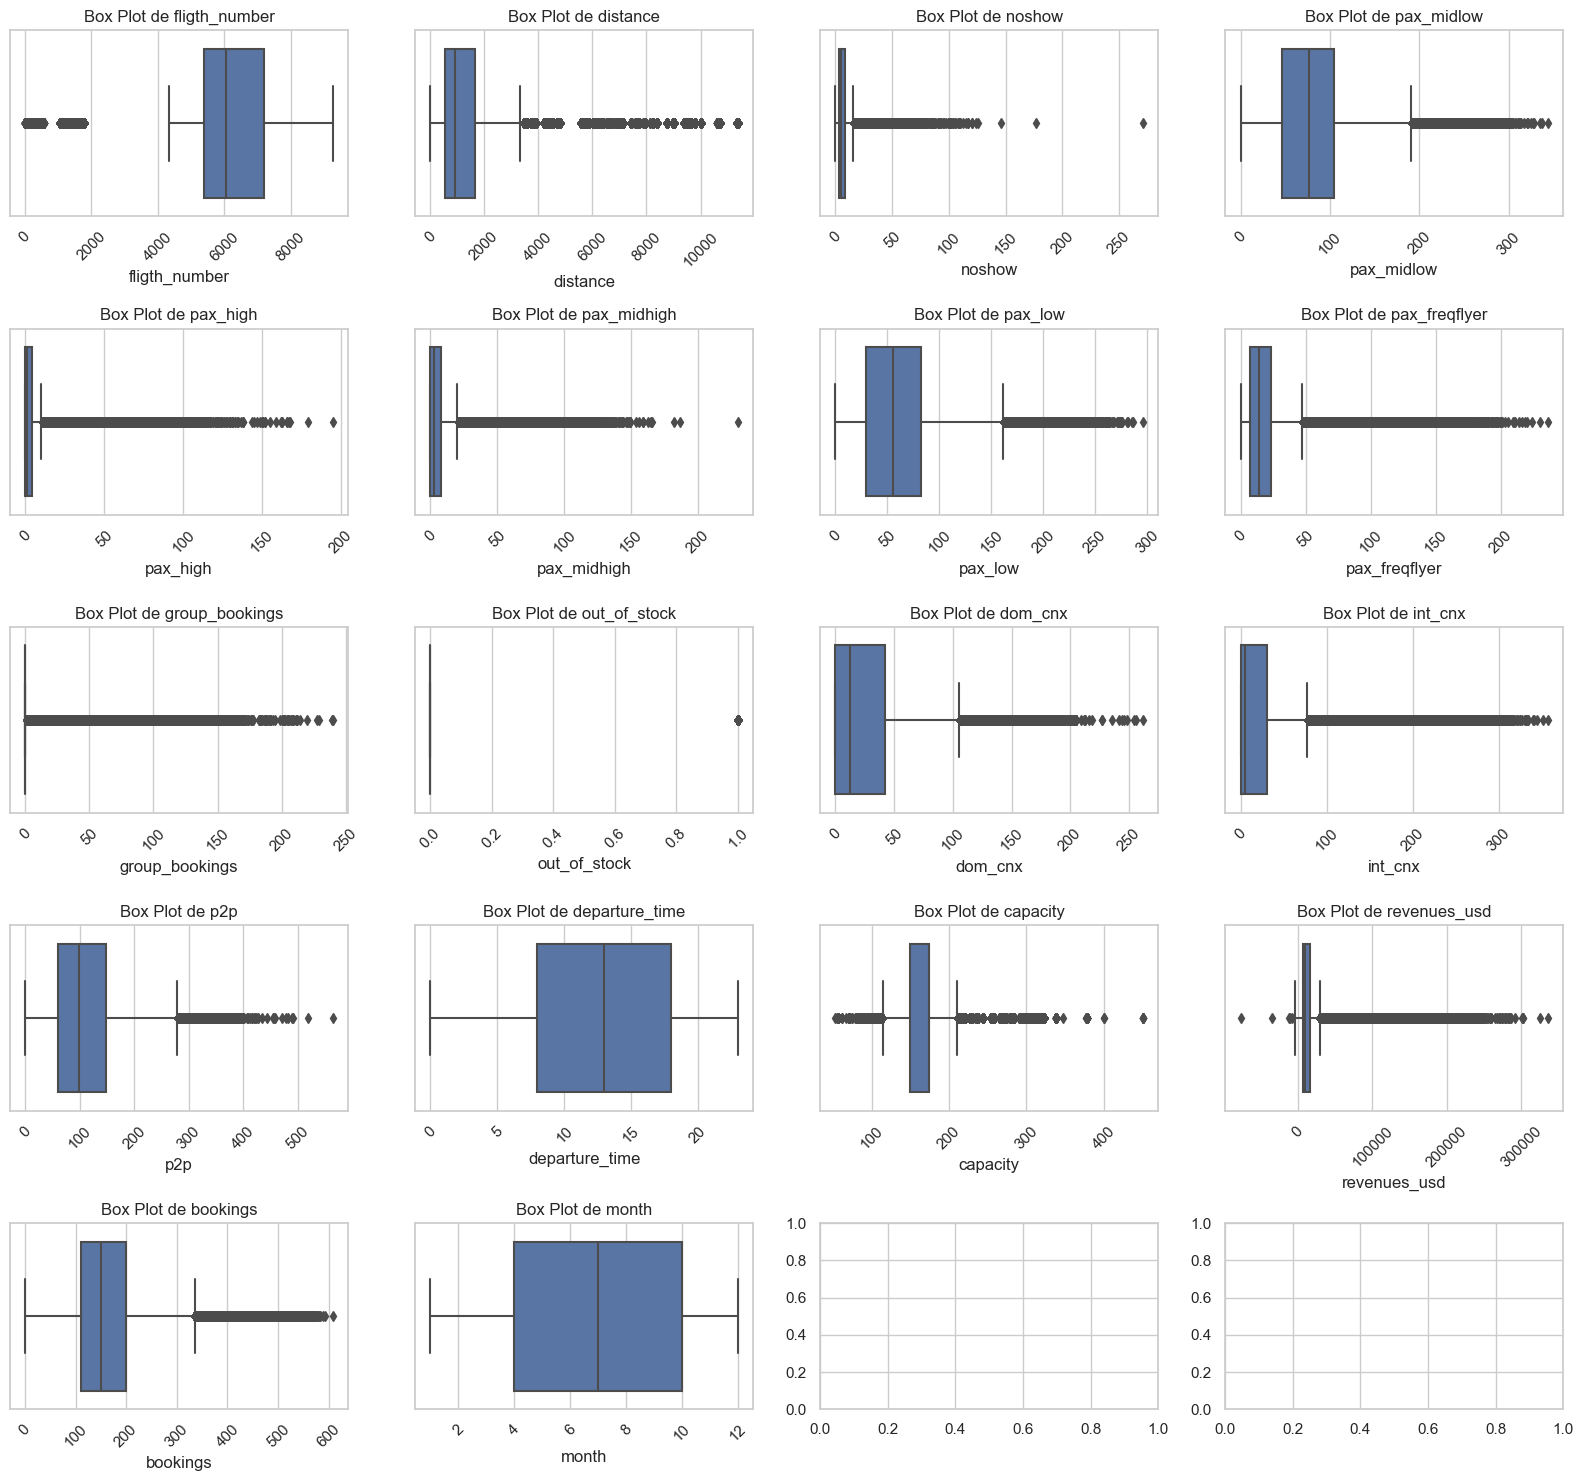

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df_train.select_dtypes(include=['number']).columns
sns.set(style="whitegrid")
plots_per_row = 4
num_rows = (len(numeric_columns) + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(16, 3 * num_rows))

for i, column in enumerate(numeric_columns):
    row = i // plots_per_row
    col = i % plots_per_row
    sns.boxplot(data=df_train, x=column, ax=axes[row, col])
    axes[row, col].set_xlabel(column)
    axes[row, col].set_title(f'Box Plot de {column}')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Podemos ver que en la variable 'revenues_usd' hay valores negativos. Estos probablemente son outliers, ya que esta variable indica ingresos en dólares, por lo que no deberían ser negativos. Como son sólo 7 valores, eliminaremos las filas que los contienen.

In [8]:
import pandas as pd
negative_revenues = df_train[df_train['revenues_usd'] < 0]
num_negative_values = len(negative_revenues)
print("Valores negativos en 'revenues_usd':")
print(negative_revenues['revenues_usd'])
print(f"Total de valores negativos: {num_negative_values}")
df_train = df_train[df_train['revenues_usd'] >= 0]

Valores negativos en 'revenues_usd':
15266    -11811.9
616862    -1487.8
685025   -34733.8
755252   -10553.2
791774    -4345.4
884149   -77206.9
892781    -8185.4
Name: revenues_usd, dtype: float64
Total de valores negativos: 7


En la variable **'noshow'** hay unos valores muy altos, especialmente uno cercano a 300, que son observaciones inusuales que pueden distorsionar la capacidad del modelo para hacer predicciones precisas. Es posible que estos valores altos sean el resultado de eventos excepcionales o errores en la recolección de datos, lo que hace que no sean representativos del comportamiento típico de los pasajeros en vuelos.

La inclusión de estos valores atípicos en el modelo puede llevar a una sobreestimación de la variabilidad en la variable objetivo 'noshow,' lo que a su vez puede afectar negativamente la calidad de las predicciones. Por lo tanto, se opta por eliminar estos valores atípicos para mejorar la precisión y la capacidad de generalización del modelo, asegurándose de que esté entrenado en datos más representativos de la población de pasajeros.

Para esto, calculamos el rango intercuartílico (IQR) de la variable 'noshow', que es una medida estadística que nos permite identificar la dispersión de los datos alrededor de la mediana. Posteriormente, definimos un umbral basado en el IQR y la regla del 1.5 veces el IQR por encima del tercer cuartil. Cualquier valor de 'noshow' que excediera este umbral fue considerado como un valor atípico. La razón para elegir el método del IQR es su capacidad para detectar valores extremos sin verse afectado por la presencia de valores atípicos en sí. 

In [9]:
import numpy as np

# Calcula el IQR de la variable 'noshow'
Q1 = np.percentile(df_train['noshow'], 25)
Q3 = np.percentile(df_train['noshow'], 75)
IQR = Q3 - Q1

# Define un umbral para valores atípicos
umbral = Q3 + 1.5 * IQR

# Identifica los valores atípicos
valores_atipicos = df_train[df_train['noshow'] > umbral]

# Cuenta los valores atípicos
cantidad_valores_atipicos = len(valores_atipicos)

# Imprime la cantidad de valores atípicos
print('IQR:', IQR)
print('umbral: ', umbral)
print(f"Número de valores atípicos en 'noshow': {cantidad_valores_atipicos}")

# Filtrar para eliminar las filas con valores atípicos
df_train = df_train[df_train['noshow'] <= umbral]

IQR: 5.0
umbral:  15.5
Número de valores atípicos en 'noshow': 42939


*¿Serán outliers los muy altos en las otras variables?*

Calcular correlaciones para ver si hay algo interesante:

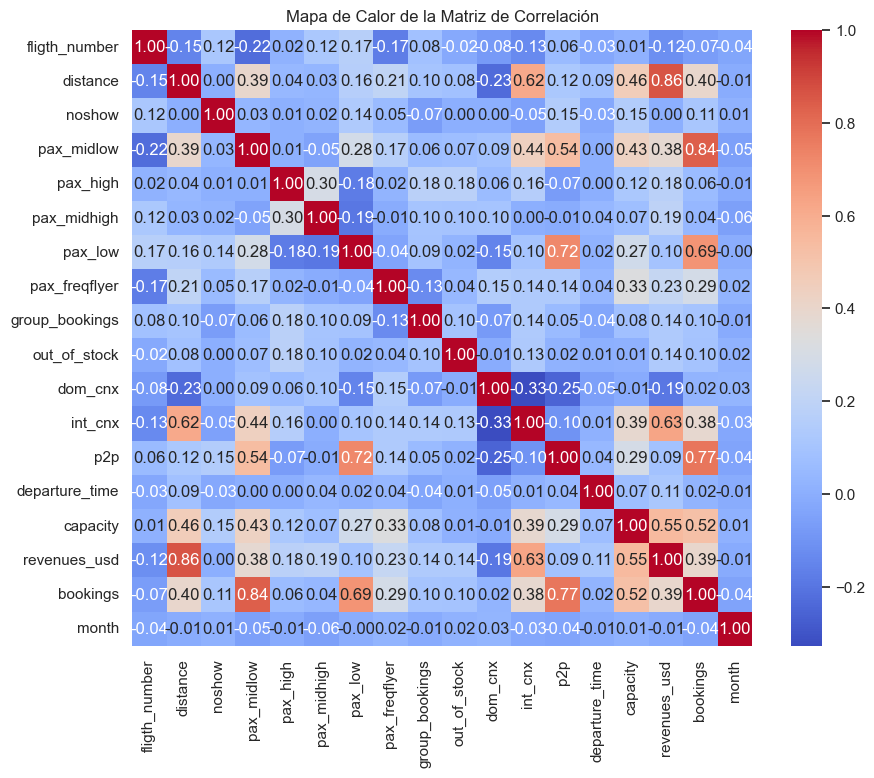

In [54]:
import pandas as pd
numeric_columns = df_train.select_dtypes(include=['number']).columns
correlation_matrix = df_train[numeric_columns].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [55]:
df_train

,fligth_number,distance,noshow,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings,month
0,8995,1394,9.0,94,2,28,94,22,19,0,1,0,239,10,174.0,10631.1,240,11
1,7061,489,0.0,100,4,4,87,25,0,0,19,9,192,19,174.0,5453.7,220,5
2,8972,2180,4.0,7,1,5,64,2,0,0,0,10,69,9,218.0,16161.0,79,5
3,6039,524,13.0,54,4,7,21,4,0,0,26,0,64,21,174.0,10828.7,90,2
4,7713,1170,14.0,21,88,18,82,0,88,1,23,3,183,12,144.0,16721.6,209,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,5.0,25,12,20,4,12,0,0,64,9,0,15,144.0,14102.1,73,10
999886,6669,3934,4.0,129,3,19,121,2,20,0,0,118,156,8,168.0,32907.8,274,5
999887,9094,1430,5.0,2,1,0,108,20,36,0,7,0,124,14,218.0,13519.3,131,4
999888,7704,1091,2.0,67,2,7,42,16,0,0,34,2,98,8,144.0,8729.6,134,4


# Forward selection

In [81]:
import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = 300000 # cerca del 30% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

In [42]:
# import numpy as np
# from sklearn.neighbors import KNeighborsRegressor
# from mlxtend.feature_selection import ExhaustiveFeatureSelector
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_val_score

# # Define una función para calcular SMAPE
# def smape(y_true, y_pred):
#     num = np.abs(y_true - y_pred)
#     den = (np.abs(y_true) + np.abs(y_pred)) / 2
#     return 100 * np.mean(2 * num / den)

# # Crea una función de puntuación personalizada basada en SMAPE
# smape_scorer = make_scorer(smape, greater_is_better=False)

# # Inicializa el modelo KNN
# knn = KNeighborsRegressor()

# # Inicializa el selector de características exhaustivas
# efs = ExhaustiveFeatureSelector(
#     knn,
#     min_features=1,
#     max_features=len(df_train_sample.columns) - 1,
#     scoring=smape_scorer,
#     print_progress=True,
#     cv=5,
# )

# # Ajusta el selector de características a tus datos
# efs = efs.fit(df_train_sample.drop('noshow', axis=1), df_train_sample['noshow'])

# # Imprime las mejores características y su puntaje
# print('Mejor conjunto de características:', efs.best_feature_names_)
# print('Mejor puntuación SMAPE:', efs.best_score_ * -1)  # Debido a que usamos greater_is_better=False

Features: 131071/131071

Mejor conjunto de características: ('fligth_number', 'pax_midhigh', 'int_cnx')
Mejor puntuación SMAPE: 120.92693336885357


In [82]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto',
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=5)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'capacity'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 121.12082970466598


In [83]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 10
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto',
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 119.95486709727865


In [84]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = round(956944/2) # 50% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 10
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto',
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'capacity'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 119.35364983250236


In [85]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = round(956944/2) # 50% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 5
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto',
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'month'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 116.76591360349262
